# Scoring model based on logistic regression

In [1]:
import os
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import WOEEncoder
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    StratifiedKFold,
    cross_validate,
)
from sklearn.pipeline import Pipeline

# Global parameters
N_SPLITS = 5
N_REPEATS = 10
SEED = 42

# Settings
np.set_printoptions(formatter={"float": lambda x: "{0:0.4f}".format(x)})  # `standard number format` mode
pd.set_option("display.max_columns", None)                                # `show whole df` mode
warnings.filterwarnings("ignore")                                         # `do not disturbe` mode
sns.set_context("paper", font_scale=1.4)                                  # sns font
sns.set_style("darkgrid")                                                 # sns theme

In [2]:
# Load data
X_train = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data_binned", "X_train.csv"))
X_test = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data_binned", "X_test.csv"))
y_train = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data_binned", "y_train.csv"))
y_test = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data_binned", "y_test.csv"))

print(X_train.shape)
print(X_test.shape)

(20000, 23)
(10000, 23)


### Feature selection

In [3]:
# Sequential feature selection
model = Pipeline([("encoder", WOEEncoder()), ("lr", LogisticRegression(random_state=SEED))])

cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
sfs = SequentialFeatureSelector(
    model,
    k_features=23,
    forward=True,
    floating=True,
    scoring="roc_auc",
    verbose=2,
    cv=cv,
    n_jobs=-1,
)

sfs = sfs.fit(X_test, y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    6.9s finished

[2021-05-24 21:15:31] Features: 1/23 -- score: 0.692438641720616[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2021-05-24 21:15:33] Features: 2/23 -- score: 0.7139918326028185[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished

[2021-05-24 21:15:35] Features: 3/23 -- score: 0.7201307863481247[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent w

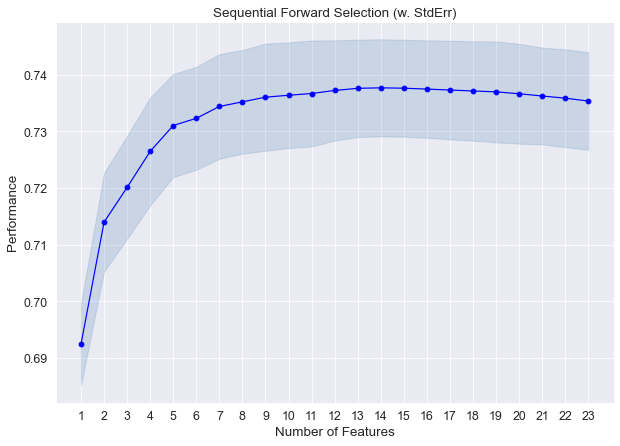

In [4]:
# Plot SFS chart
fig = plot_sfs(sfs.get_metric_dict(), kind="std_err", figsize=[10, 7])
plt.title("Sequential Forward Selection (w. StdErr)")

plt.savefig(os.path.join("Experiment_results", "LogisticRegression", "lr_SFS.png"), facecolor="w")

In [5]:
# Print chosen variables
results = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
final_variables = list(results["feature_names"][10])
final_variables

['EDUCATION',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_4',
 'BILL_AMT1',
 'BILL_AMT3',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT4']

In [6]:
# Drop unused variables
X_train = X_train[final_variables]
X_test = X_test[final_variables]

### Model

In [7]:
# Model definition
model = Pipeline([("encoder", WOEEncoder()), ("lr", LogisticRegression(random_state=SEED))])

In [8]:
# Cross-validation
cv = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=SEED)
scores = cross_validate(
    model, X_train, np.ravel(y_train), scoring="roc_auc", cv=cv, return_train_score=True, n_jobs=-1
)
mean_train_auc = scores["train_score"].mean()
mean_val_auc = scores["test_score"].mean()
std_val_auc = scores["test_score"].std()

# Test
model.fit(X=X_train, y=np.ravel(y_train))
preds = model.predict_proba(X_test)[::, 1]
test_auc = metrics.roc_auc_score(y_test, preds)
ap = metrics.average_precision_score(y_test, 1-preds, pos_label=0)

# Print the results
print(f"mean_train_GINI:\t {np.round(mean_train_auc * 2 - 1, 4)}")
print("mean_dev_GINI:\t\t", np.round(mean_val_auc * 2 - 1, 4), f"({np.round(std_val_auc, 4)})")
print(f"test_GINI:\t\t {np.round(test_auc * 2 - 1, 4)}")
print(f"AP:\t\t\t {np.round(ap, 4)}")

mean_train_GINI:	 0.4782
mean_dev_GINI:		 0.4762 (0.0093)
test_GINI:		 0.4752
AP:			 0.5036


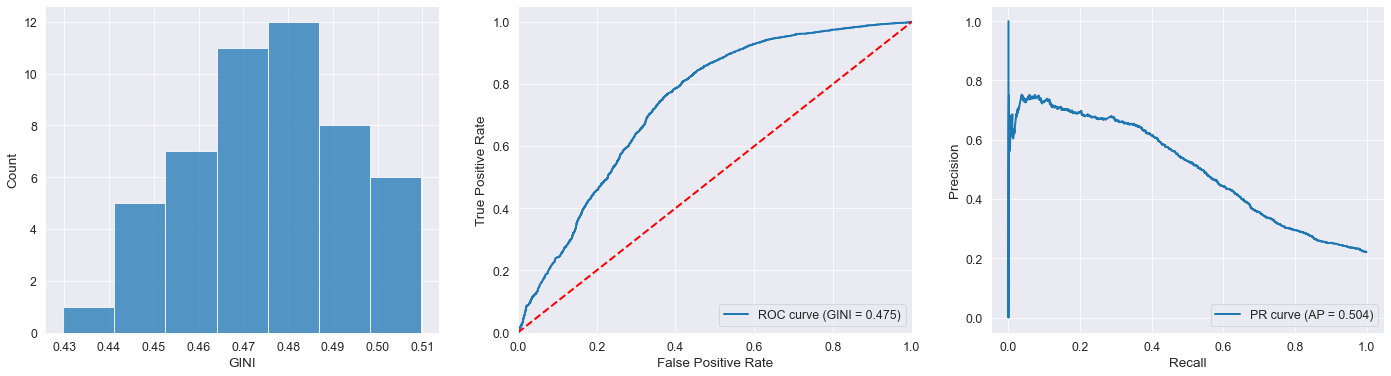

In [9]:
# Boxplot
fig, axs = plt.subplots(1, 3, figsize=(24, 6))
fig1 = sns.histplot(scores["test_score"] * 2 - 1, ax=axs[0])
fig1.set_xlabel("GINI")

# ROC
preds = model.predict_proba(X_test)[::, 1]
test_auc = metrics.roc_auc_score(y_test, preds)

fpr, tpr, _ = metrics.roc_curve(y_test, preds)
lw = 2
axs[1].plot(fpr, tpr, lw=lw, label="ROC curve (GINI = %0.3f)" % (test_auc * 2 - 1))
axs[1].plot([0, 1], [0, 1], color="red", lw=lw, linestyle="--")
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")
axs[1].legend(loc="lower right")

# PR
precision, recall, _ = metrics.precision_recall_curve(y_test, 1-preds, pos_label=0)
lw = 2
axs[2].plot(recall, precision, lw=lw, label="PR curve (AP = %0.3f)" % ap)
axs[2].set_xlabel("Recall")
axs[2].set_ylabel("Precision")
axs[2].legend(loc="lower right")

plt.savefig(os.path.join("Experiment_results", "LogisticRegression", "lr_cv_roc.png"), facecolor="w")

In [10]:
# Save results for final summary
res = {
    "val_scores": scores["test_score"] * 2 - 1,
    "fpr_tpr": [fpr, tpr],
    "pr_rec": [precision, recall],
    "test_gini": test_auc * 2 - 1,
    "dev_gini": [mean_val_auc * 2 - 1, std_val_auc],
    "optimization_time": 0,
    "ap": ap,
}

joblib.dump(res, os.path.join("Experiment_results", "LogisticRegression", "lr_res.pth"))

['Experiment_results\\LogisticRegression\\lr_res.pth']

                          0         1         2        3         4         5         6         7         8         9        10        11
score_uncalibrated  0.904995  0.909951  0.899223  0.90737  0.914921  0.893745  0.902286  0.910211  0.912468  0.902007  0.89951  0.828689
%Agreements         0.290000  0.280000  0.280000  0.25000  0.230000  0.220000  0.220000  0.210000  0.200000  0.190000  0.18000  0.180000


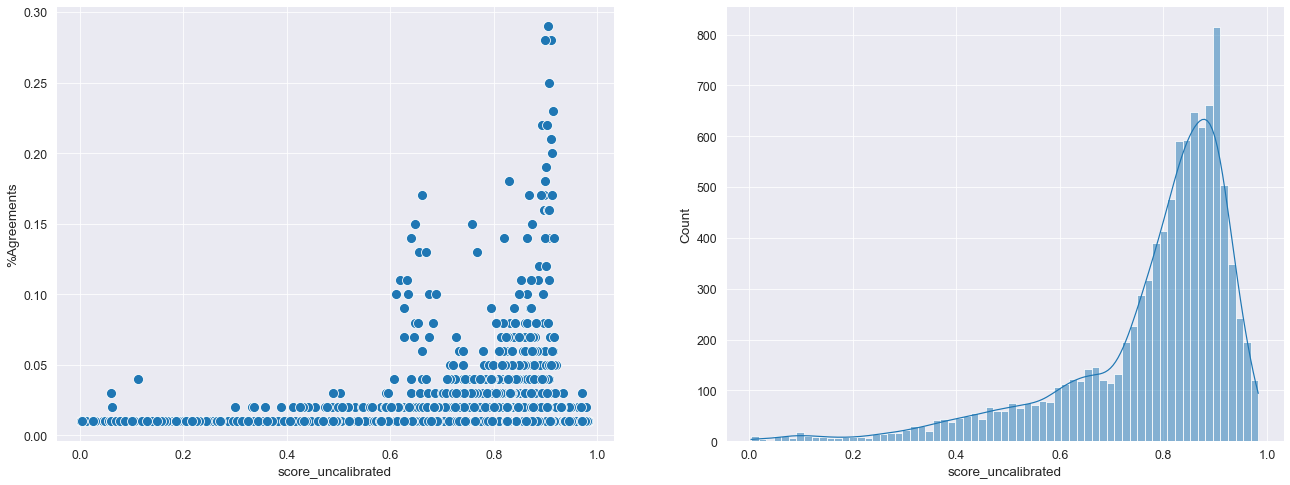

In [11]:
# Uncalibrated score distribution
preds_uncalibrated = pd.DataFrame(preds, columns=["score_uncalibrated"])

score_distr = preds_uncalibrated['score_uncalibrated'].value_counts()/preds_uncalibrated.shape[0]*100
score_distr_df = pd.concat([pd.Series(list(score_distr.index), name='score_uncalibrated'), pd.Series(list(score_distr), name='%Agreements')], axis=1)
print(score_distr_df.head(12).T.to_string())

fig, axs = plt.subplots(1, 2, figsize=(22,8))
sns.scatterplot(data=score_distr_df, x="score_uncalibrated", y="%Agreements", s=100, ax=axs[0])
sns.histplot(data=preds_uncalibrated, x="score_uncalibrated", kde=True, ax=axs[1])

plt.savefig(os.path.join("Experiment_results", "LogisticRegression", "lr_uncalib_score_distr.png"), facecolor="w")

                      0       1      2       3       4       5       6       7       8       9       10      11
score_calibrated  583.00  591.00  588.0  580.00  577.00  611.00  586.00  594.00  581.00  597.00  613.00  614.00
%Agreements         1.42    1.31    1.3    1.28    1.24    1.22    1.16    1.14    1.14    1.12    1.11    1.11


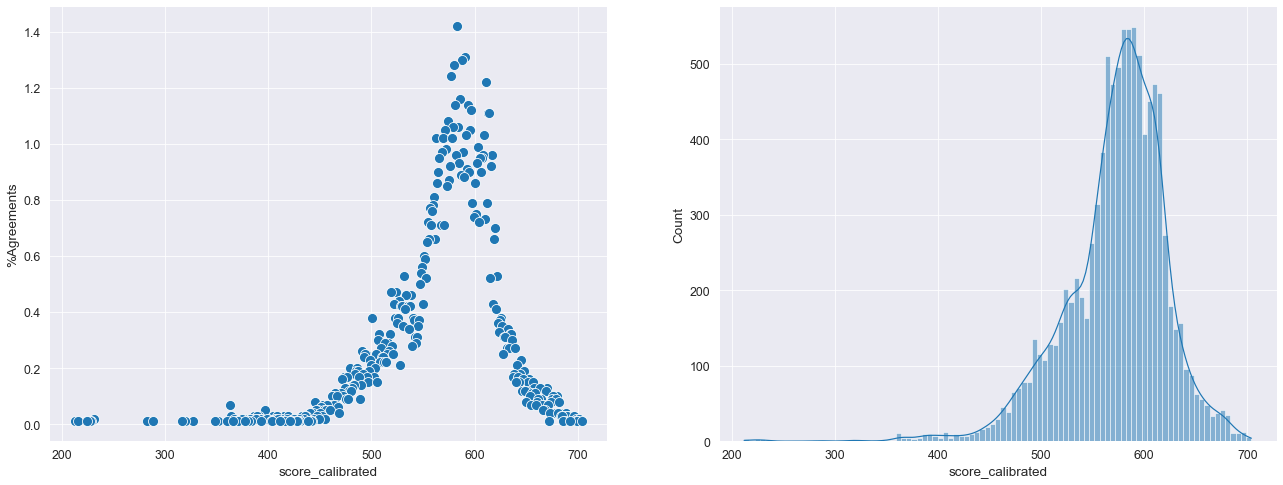

In [12]:
# Score distribution
preds_calibrated = pd.DataFrame(np.round(50*np.log(preds/(1-preds))+500), columns=["score_calibrated"])

score_distr = preds_calibrated['score_calibrated'].value_counts()/preds_calibrated.shape[0]*100
score_distr_df = pd.concat([pd.Series(list(score_distr.index), name='score_calibrated'), pd.Series(list(score_distr), name='%Agreements')], axis=1)
print(score_distr_df.head(12).T.to_string())

fig, axs = plt.subplots(1, 2, figsize=(22,8))
sns.scatterplot(data=score_distr_df, x="score_calibrated", y="%Agreements", s=100, ax=axs[0])
sns.histplot(data=preds_calibrated, x="score_calibrated", kde=True, ax=axs[1])

plt.savefig(os.path.join("Experiment_results", "LogisticRegression", "lr_score_distr.png"), facecolor="w")

In [13]:
# Logistic regression coefficients
coefs = pd.DataFrame(
    zip(X_train.columns, model["lr"].coef_[0]), columns=["Variable", "Coef"]
)
coefs_sorted = coefs.reindex(coefs["Coef"].abs().sort_values(ascending=False).index)
print(coefs_sorted.T.to_string())

                 2         4         8         3         7          5         9          0         1          6
Variable     PAY_0     PAY_4  PAY_AMT2     PAY_2  PAY_AMT1  BILL_AMT1  PAY_AMT4  EDUCATION       AGE  BILL_AMT3
Coef     -0.533974 -0.203755  0.160242 -0.151726   0.09669   0.087134  0.082872   0.059041 -0.031106  -0.026637


### Performance vs sample size

In [14]:
# Examine relationship between model performance and sample size
n_sample = [50, 100, 500, 1000, 2000, 3000, 5000, 7000, 10000, 20000]

experiment = pd.DataFrame(n_sample, columns=["Training set size"])
experiment["Mean train GINI"] = np.NaN
experiment["Mean validation GINI"] = np.NaN
experiment["Std validation GINI"] = np.NaN
experiment["Test GINI"] = np.NaN

for i in range(len(n_sample)):
    X_train = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data_binned", "X_train.csv"))[final_variables]
    X_test = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data_binned", "X_test.csv"))[final_variables]
    y_train = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data_binned", "y_train.csv"))
    y_test = pd.read_csv(os.path.join("Data", "data_preprocessed", "taiwan_data_binned", "y_test.csv"))

    if n_sample[i] < 20000:
        X_train = X_train.sample(n_sample[i], random_state=SEED)
        y_train = y_train.sample(n_sample[i], random_state=SEED)

    model = Pipeline([("encoder", WOEEncoder()), ("lr", LogisticRegression(random_state=SEED))])

    # Cross-validation
    cv = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=SEED)
    scores = cross_validate(model, X_train, np.ravel(y_train), scoring="roc_auc", cv=cv, return_train_score=True, n_jobs=-1)
    mean_train_auc = scores["train_score"].mean()
    mean_val_auc = scores["test_score"].mean()
    std_val_auc = scores["test_score"].std()

    # Test
    model.fit(X=X_train, y=np.ravel(y_train))
    preds = model.predict_proba(X_test)[::, 1]
    test_auc = metrics.roc_auc_score(y_test, preds)

    # Save the results to daraframe
    experiment["Mean train GINI"][i] = mean_train_auc * 2 - 1
    experiment["Mean validation GINI"][i] = mean_val_auc * 2 - 1
    experiment["Std validation GINI"][i] = std_val_auc
    experiment["Test GINI"][i] = test_auc * 2 - 1

In [15]:
experiment

,Training set size,Mean train GINI,Mean validation GINI,Std validation GINI,Test GINI
0,50,0.737949,0.232619,0.206607,0.177772
1,100,0.544278,0.160114,0.144295,0.410717
2,500,0.443679,0.363085,0.053879,0.459464
3,1000,0.457339,0.413807,0.033834,0.471317
4,2000,0.485216,0.464930,0.023964,0.478550
5,3000,0.479134,0.465048,0.026737,0.477460
6,5000,0.471607,0.463459,0.020952,0.477797
7,7000,0.474777,0.468750,0.014136,0.477032
8,10000,0.486296,0.482610,0.012747,0.476655
9,20000,0.478156,0.476228,0.009339,0.475167


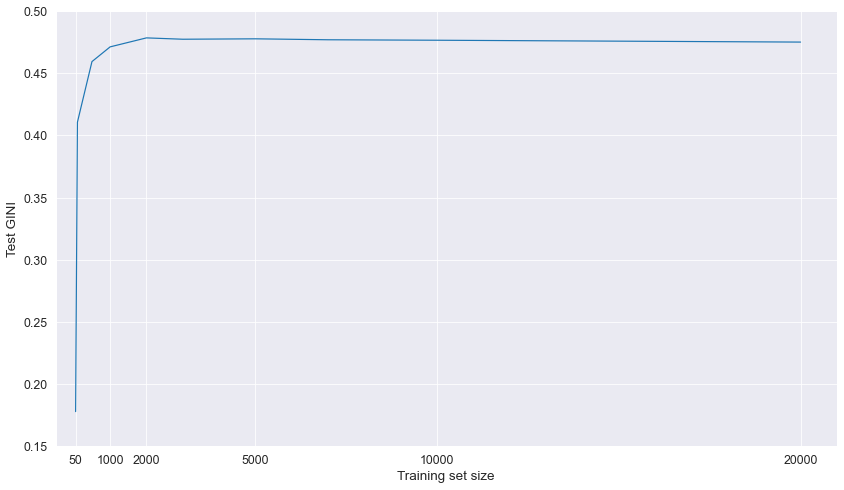

In [16]:
# Plot experiment results
fig, ax = plt.subplots(figsize=(14, 8))
sns.lineplot(data=experiment, x="Training set size", y="Test GINI")
ax.set_ylim([0.15, 0.5])
ax.set_xlim([-500, None])
ax.set_xticks([50, 1000, 2000, 5000, 10000, 20000])

In [17]:
# Save results for final summary
joblib.dump(experiment, os.path.join("Experiment_results", "LogisticRegression", "lr_experiment.pth"))

['Experiment_results\\LogisticRegression\\lr_experiment.pth']